
# Mini-Projet TP 1 :  Détection d'activités à partir de caractéristiques extraites d'accéléromètre 

## Nom du binôme : Thomas SILVESTRE & Stéphane LOPPINET

Dans ce projet, vous prédirez 5 différentes activités humaines en utilisant des méthodes supervisées :

 **2-Assis,3-Debout, 5-Velo, 6-Marche Nordique, 8-Repassage**

en utilisant le capteur d'accéléromètre placé à deux endroits différents du corps :  poignet et cheville.

Pour réaliser cette classification, nous disposons de profils temporels des signaux extraits d'accéléromètre. 
les mesures respectivement en $ms^{-2}$ sont prélevées sur les 3-axes à une fréquence d'échantillonnage de 100Hz. 
Les profils temporels comportent 128 pas de temps et chaque mesure est étiquetée.

<img src="./HARDataset.JPG" width="800" height="600"  >


Vous disposez des matrices suivantes
-  **X_train_Cheville_TP1.npy** et **X_test_Cheville_TP1.npy** deux matrices d'apprentissage et de test de dimensions 384 (concatenation des signaux de 128 pas de temps sur les 3 axes X, Y et Z) du capteur d'accéléromètre situé sur la cheville.
-  **LabelTrain_TP1.npy** et **LabelTest_TP1.npy** les vecteurs respectifs des labels pour la base d'apprentissage et de test dont le numéro correspond à une des 5 activités présentées ci-dessus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
import sklearn

# Chargement des données 

In [2]:
# CAPTEUR CHEVILLE 
Xtrain_Cheville=np.load('./Xtrain_Cheville_TP1.npy')
print('Taille de la base d apprentissage :', Xtrain_Cheville.shape)

# Chargement des données de test
Xtest_Cheville=np.load('./Xtest_Cheville_TP1.npy')
print('Taille de la base de test :', Xtest_Cheville.shape)

# LABELS : 
y_train=np.load('./LabelTrain_TP1.npy')
y_test=np.load('./LabelTest_TP1.npy')
print('Taille label apprentissage :',y_train.shape, 'Taille label test :',y_test.shape)

Taille de la base d apprentissage : (5791, 384)
Taille de la base de test : (2483, 384)
Taille label apprentissage : (5791,) Taille label test : (2483,)


In [3]:
print("Premier exemple :", Xtrain_Cheville[0][:10]) # Affiche les 10 premières valeurs
print("\nLabel du premier exemple :", y_train[0])
print("\nLabel du premier exemple :", y_train[1])
print("\nLabel du premier exemple :", y_train[2])
print("\nLabel du premier exemple :", y_train[3])

Premier exemple : [9.54557037 9.62442017 9.58150005 9.39216995 9.47212982 9.61892033
 9.46772003 9.39818001 9.43620014 9.54716969]

Label du premier exemple : 2

Label du premier exemple : 2

Label du premier exemple : 5

Label du premier exemple : 6


- On peut voir que le train du dataset est composé de deux parties :
La partie Xtrain_Cheville_TP1.npy et la partie LabelTrain_TP1.npy.
Xtrain va contenir toutes les mesures sans le résultat / la correction.
LE résultat avérré se situe dans le LabelTrain. Ainsi, Xtrain va être confronté au résultat attendu et va apprendre de ses erreurs (dans le cas du supervisé
)

### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [4]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred,label):
  # Correspondance entre la partition du clusterin y_pred et les classes de la vérité terrain label
  reference_labels = retrieve_info(y_pred,label)
  number_labels = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
    number_labels[i] = reference_labels[y_pred[i]]
  return number_labels


# Analyse des données
## Histogramme et vraissemblance
### Tout axe confondu
- Comme dans le cours avec les poissons (saumon vs bar), on va essayer de représenter les valeurs des capteurs sous forme d'histogramme pour trouver des patterns notamment la vraissemblance donc, qui est la probabilité d'avoir une valeur pour tous les capteurs (X) sachant que l'activité physique Y. On prend naïvement toutes les mesures des capteurs (peu importe lesquels) pour chaque activité et on trace l'histogramme puis la fonction de densité de probabilité qui suit l'histogramme. 

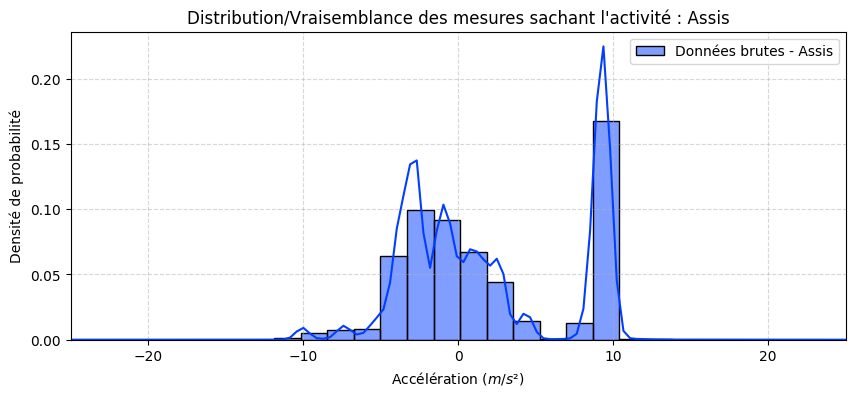

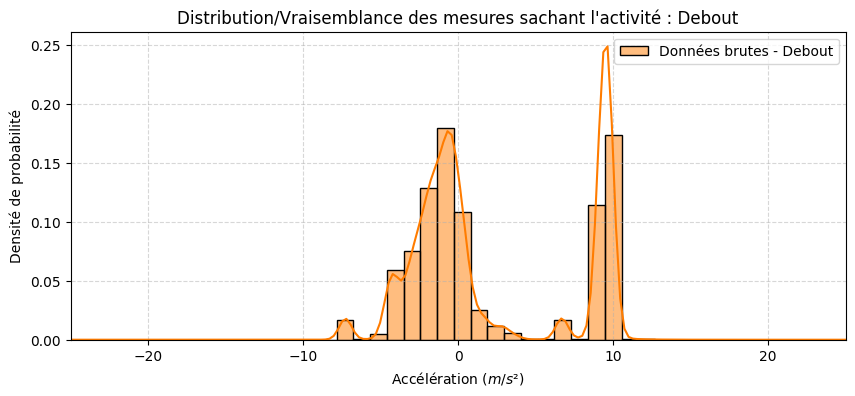

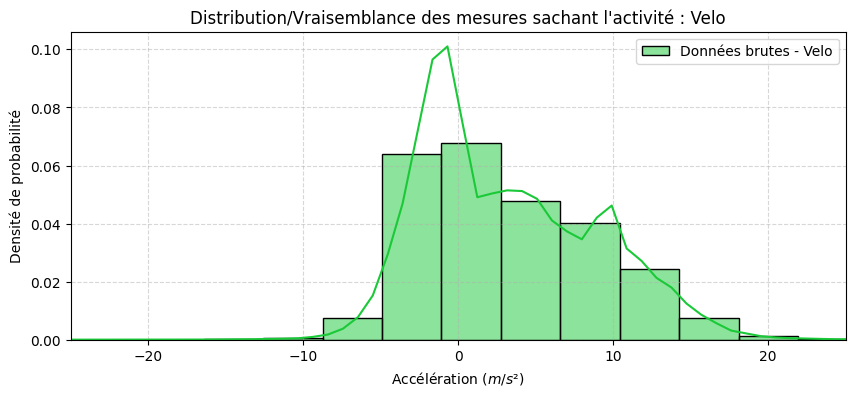

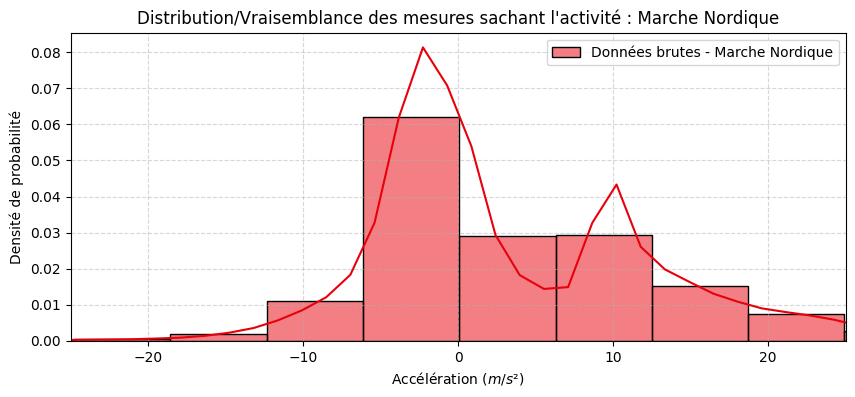

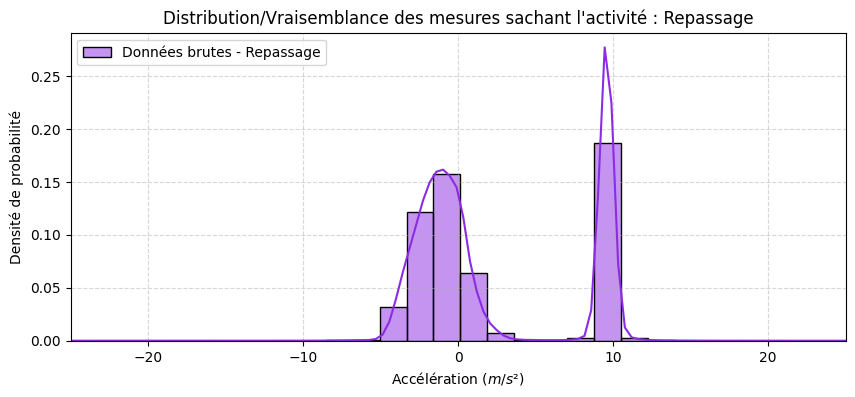

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def afficher_vraisemblance_activite(X, y, activite_id, nom_activite, couleur):
    plt.figure(figsize=(10, 4))
    
    # Extraction des données pour l'activité concernée
    data_activite = X[y == activite_id].flatten()
    
    # On trace l'histplot (en activant la courbe de densité qui suit l´histplot)
    sns.histplot(data_activite, 
                 color=couleur, 
                 kde=True,
                 stat="density",
                 bins=50,
                 label=f"Données brutes - {nom_activite}")
    
    plt.title(f"Distribution/Vraisemblance des mesures sachant l'activité : {nom_activite}")
    plt.xlabel("Accélération ($m/s²$)")
    plt.ylabel("Densité de probabilité")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-25, 25) 
    plt.show()


couleurs = sns.color_palette("bright", 5)
afficher_vraisemblance_activite(Xtrain_Cheville, y_train, 2, "Assis", couleurs[0])
afficher_vraisemblance_activite(Xtrain_Cheville, y_train, 3, "Debout", couleurs[1])
afficher_vraisemblance_activite(Xtrain_Cheville, y_train, 5, "Velo", couleurs[2])
afficher_vraisemblance_activite(Xtrain_Cheville, y_train, 6, "Marche Nordique", couleurs[3])
afficher_vraisemblance_activite(Xtrain_Cheville, y_train, 8, "Repassage", couleurs[4])

#### Observations
- On voit bien des pics se dessiner que l'on pourrait donc approximer par des fonctions de Gauss. 
Sauf qu´il y a un problème : Le nombre de pics.
En effet, que ça soit pour le repassage, être assis et être debout, on a 2 pics qui se dessinent, ce qui est dérangeant car dans notre cours, nous avons vu que la classification bayésenne marche bien notamment si la densité empirique est unimodale (un seul pic donc). 
Dans notre cas on aura, si on essaye d'estimer les paramètres d'une gaussienne, on aura une moyenne des deux pics comme sur le schéma ci-dessous (en rouge), ce qui va certainement fausser l'aprentissage du modèle et sa précision future.

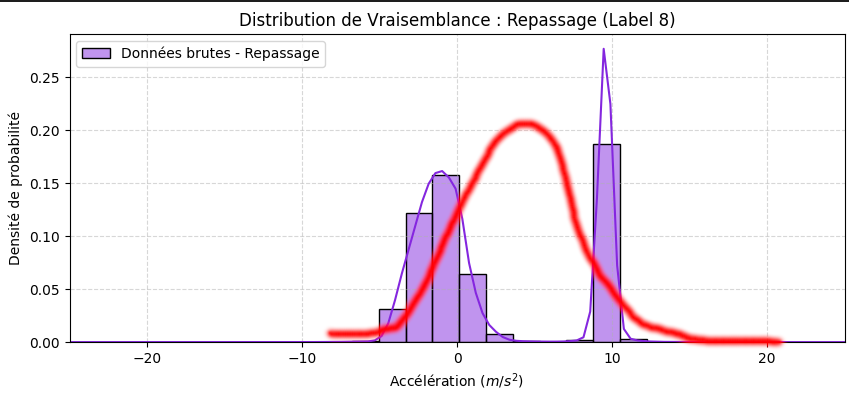

### Distinguer chaque axe
- Avant de tester l'apprentissage pour vérifier notre hypothèse. Essayons de raffiner un peu notre histogramme pour distinguer les différents axes dans les valeurs afin d'avoir une meilleure vision de nos données et de vérifier par la même occasion qu'elles sont cohérentes.


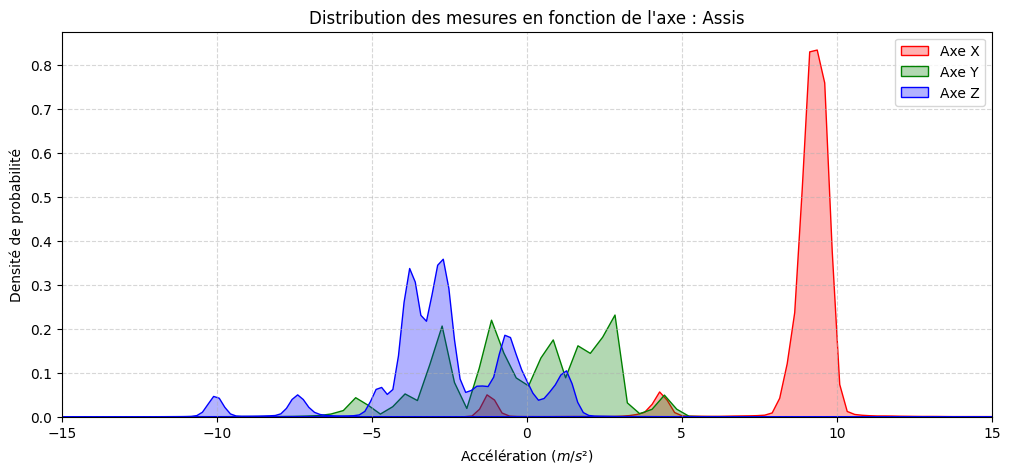

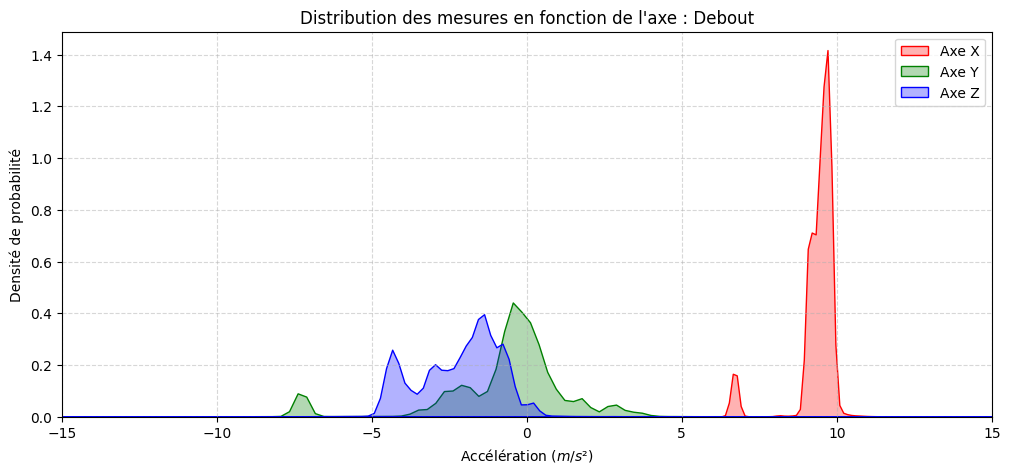

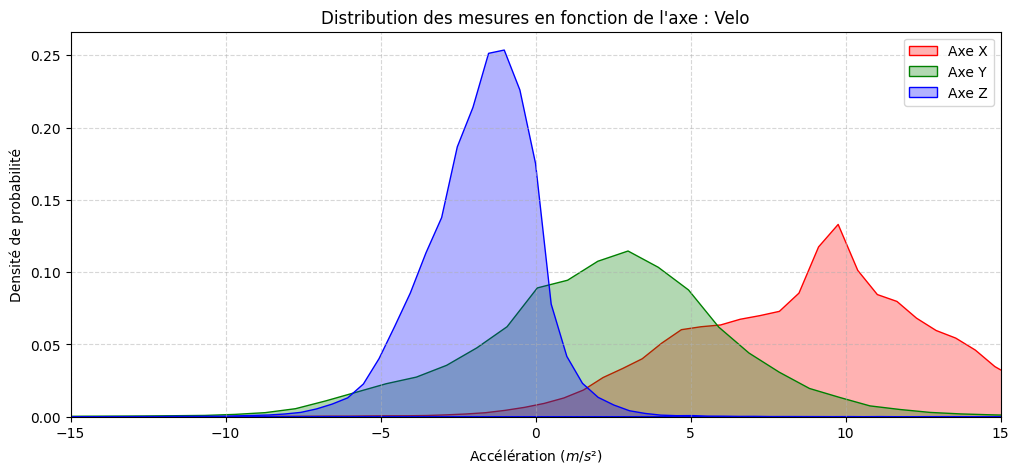

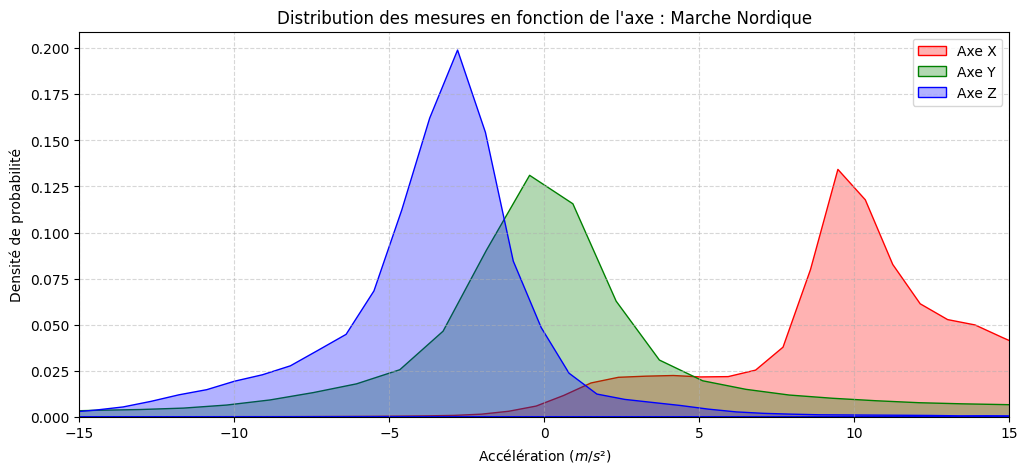

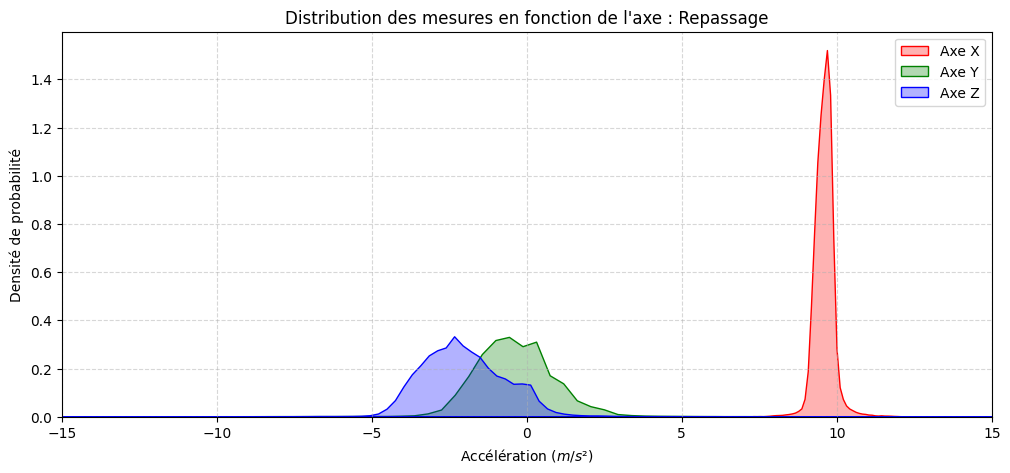

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def afficher_vraissemblances_par_axe(X, y, activite_id, nom_activite):
    data = X[y == activite_id]
    
    # On distingue les mesures de chaque capteur en fonction de leur axe (X, Y, Z). 
    # Comme dit dans l'énoncé, les 384 mesures sont organisées en 3 blocs de 128 mesures chacun pour chaque axe.
    data_x = data[:, 0:128].flatten()
    data_y = data[:, 128:256].flatten()
    data_z = data[:, 256:384].flatten()
    
    plt.figure(figsize=(12, 5))
    
    sns.kdeplot(data_x, label='Axe X', fill=True, color='red', alpha=0.3)
    sns.kdeplot(data_y, label='Axe Y', fill=True, color='green', alpha=0.3)
    sns.kdeplot(data_z, label='Axe Z', fill=True, color='blue', alpha=0.3)
    
    plt.title(f"Distribution des mesures en fonction de l'axe : {nom_activite}")
    plt.xlabel("Accélération ($m/s²$)")
    plt.ylabel("Densité de probabilité")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-15, 15)
    plt.show()

afficher_vraissemblances_par_axe(Xtrain_Cheville, y_train, 2, "Assis")
afficher_vraissemblances_par_axe(Xtrain_Cheville, y_train, 3, "Debout")
afficher_vraissemblances_par_axe(Xtrain_Cheville, y_train, 5, "Velo")
afficher_vraissemblances_par_axe(Xtrain_Cheville, y_train, 6, "Marche Nordique")
afficher_vraissemblances_par_axe(Xtrain_Cheville, y_train, 8, "Repassage")
 

#### Observations
- Pour les activités comme Assis, Debout et le repassage, les données sont selon moi plutôt cohérentes avec la physique basique que l'on m'a enseigné. En effet, à l'arrêt, on a bien la force gravitationnelle qui s'exerce sur nous. La cheville n'y échappe pas, d'où l'accélération à 9.81 m-s² représenté sur l'axe X de notre histogramme.
- Pour le vélo, nos pieds étant sur les pédales donc suivant le mouvement circulaire du pédalier.
    - On peut imaginer X être l'accélération du haut/bas (axe vertical du pédalier) car pic à 9.81 m-s² comme dit précédemment
    - On peut imaginer Z être l'accélération d'avant en arrière car la densité est très étalée (pas de champ gravitationnel sur cet axe et pied qui va aussi bien en avant qu'en arrière)
    - On peut imaginer Y être le déplacement latéral sur la pédale qui théoriquement ne varie pas ou très peu lorsque l'on pédale une fois le pied placé sur la pédale, d'où le pic proche de 0 m-s² (et aussi après élimination de la courbe verte)
- On peut appliquer le même raisonnement que le vélo pour la marche nordique. On est censé marcher droit pas latéralement et nous sommes aussi soumis au champ gravitationnel.
- Enfin, pour le repassage, on reste statique comme assis et debout. Les autres axes ne sont pas bougés non plus car statique, on pourrait regarder les mesures des bras plutôt.

# Partie I : Classification des activités sans prétraitement

Réaliser une classification des activités par deux méthodes d'apprentissage supervisé  de votre choix en utilisant les codes des TP précédents.


## Méthodes supervisées  : 
Indiquer quelle est la méthode supervisée et les paramètres utilisées.  Calculer la matrice de confusion associée, le pourcentage de bonne classification et commentez les résultats.


## Apprentissage Bayésien (EN: Gaussian Naive Bayes)

In [7]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(Xtrain_Cheville, y_train)

,priors,None
,var_smoothing,1e-09


### Évaluation du modèle Bayésien entrainé

Dans ce projet, la séparation entre jeu de données d'apprentissage et jeu de données de test a déjà été réalisé par la professeure. Si ce n´est pas le cas, il faut séparer une partie de notre dataset pour l'évaluation finale (nommée test_dataset), on peut imaginer par exemple une répartition (80% train et 20% test typiquement). La librairie `scikit-learn` permet de faire ça simplement avec la fonction `train_test_split`.

Cette étape de séparation est primordiale notamment pour éviter de fausser les résultats car notre but est d'avoir un modèle qui sait prédire l'activité en fonction de nouvelles mesures non connues. Le modèle doit savoir généraliser. L'évaluer sur un dataset sur lequel il a appris nous prouverait qu'il sait régurgiter mot à mot ce qu'il appris mais certainement pas qu'il sait classer de nouvelles données (prédire une activité en fonction de nouvelles mesures).  

`Scikit-learn` met à disposition deux fonctions
- Une pour calculer la matrice de confusion (`confusion_matrix`)
- Une pour calculer la matrice de pourcentage de précision (`accuracy_score`)

Il suffit de donner les valeurs de la vérité et les prédictions faites par le modèle.

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, gnb_model.predict(Xtest_Cheville))
print("Matrice de confusion :")
print(cm)

Matrice de confusion :
[[ 24 185  15  43 246]
 [ 11  67  34   1 379]
 [ 26   6 325  21  16]
 [  1   3   5 428  17]
 [ 22  78   3   0 527]]


C'est moche... 

Moi je veux le beau schéma comme en cours !

=> `Seaborn` a une fonction pour ça : `heatmap`

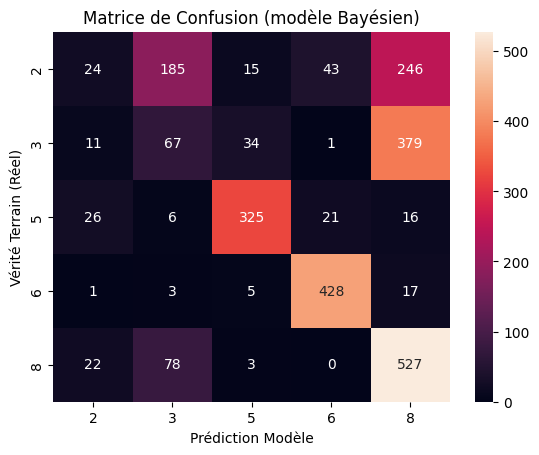

In [9]:
sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (modèle Bayésien)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

On peut afficher la précision du modèle sur le jeu de données de test en pourcentage

In [10]:
accuracy = accuracy_score(y_test, gnb_model.predict(Xtest_Cheville))
print(f"Pourcentage de bonne classification (modèle Bayésien): {accuracy * 100:.2f}%")

Pourcentage de bonne classification (modèle Bayésien): 55.22%


#### Observations

Comme attendu, ce modèle ne performe pas bien sur ce jeu de données avec une précision d'environ 1/2. Les raisons ont été abordées lors de la phase d'analyse des données (Vraissemblance et histogrammes).

// TODO intepréter pour chaque valeur de la matrice de confusion (est ce la covariance représentée ?)

## Apprentissage K Plus proches voisins
Non vu en cours, cette méthode d'apprentissage est réputée pour les problèmes de classification.
Pour la comprendre, rien de mieux qu'un schéma issu de cette [vidéo explicative](https://www.youtube.com/watch?v=gs9E7E0qOIc)).

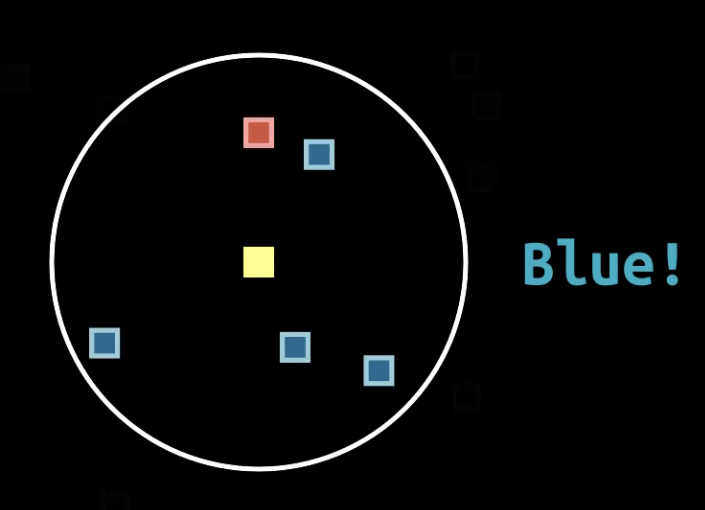

Pour chaque nouveau point, on regarde les `k` plus proches voisins. Ce nouveau point appartient au groupe le plus représenté par ses voisins.

Mais comment définir `k` ? 
Si k est trop petit, le modèle va sur-apprendre (EN: Overfit) car pas assez de voisins pour généraliser.
Si k est trop grand, le modèle va sous-apprendre (EN: Underfit). En voulant trop généraliser/rassembler, on n'en perd les spécificités, les caractéristiques importantes de chaque groupe (activité dans notre cas). Mon intervalle de mesures est trop grand pour pouvoir prendre une décision éclairée.

On va donc procéder empiriquement en prenant successivement des valeurs pour `k`. Dans notre cas, de 1 à 20.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
# Avec k=5 car on a 5 classes (2-Assis,3-Debout, 5-Velo, 6-Marche Nordique, 8-Repassage)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtrain_Cheville, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


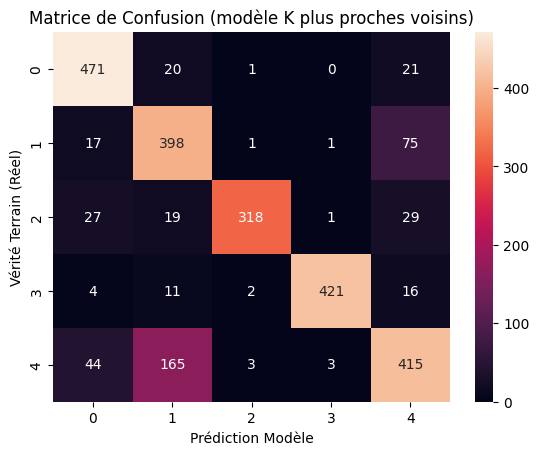

Pourcentage de bonne classification (modèle K plus proches voisins): 81.47%


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, knn.predict(Xtest_Cheville))

sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"Matrice de Confusion (modèle K plus proches voisins)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(y_test, knn.predict(Xtest_Cheville))
print(f"Pourcentage de bonne classification (modèle K plus proches voisins): {accuracy * 100:.2f}%")


#### Observations
Après plusieurs essais empiriques de valeurs de k, on trouve comme valeur optimal k=5 pour une précision de 81.47%, ce qui est bien meilleur que la classification Bayséenne. En se basant sur les plus proches voisins, nous ne sommes pas limités par une fonction gaussienne qui ne distingue pas les 2 pics d'accélération, ce qui nous donne des meilleurs résultats. Il confond tout de même debout et repassage, ce qui parait logique car la cheville n'est pas censé bouger dans les deux cas ou très peu.

#### Voie d'amélioration
Nous avons basé notre détection des plus proches voisins en les triant par distance euclidienne, mais il existe différentes façons de calculer une distance entre deux points qui pourraient peut-être se révéler meilleures (distance de Minkowski ou Manhattan ci-dessous).

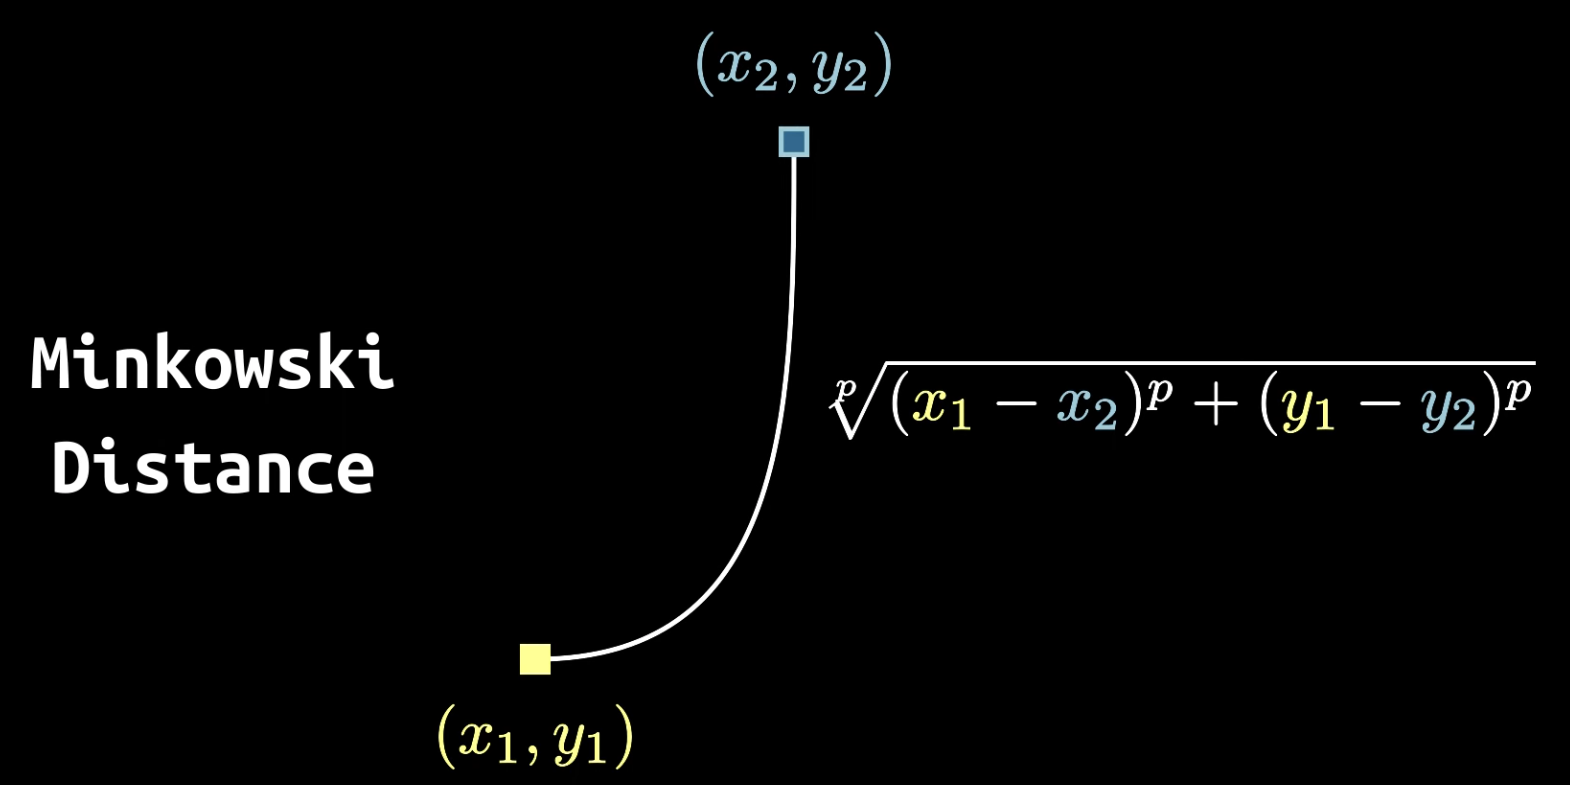

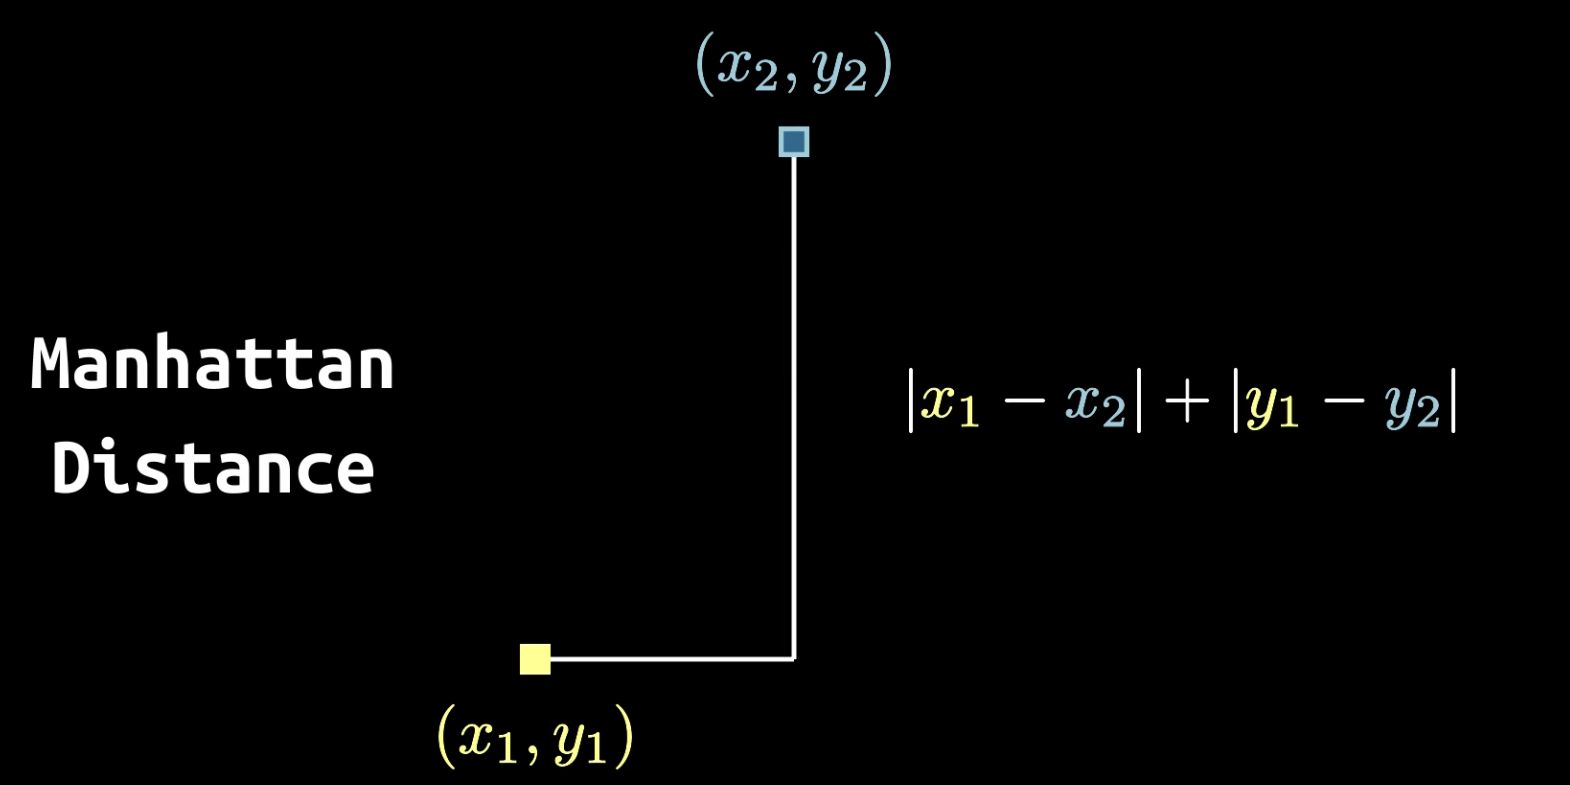

## Conclusion et limites des méthodes supervisées 
// TODO 

## Méthode non supervisée

indiquer quelle est la méthode non supervisée de votre choix et calculer la matrice de confusion associée. 


## Apprentissage K-means
Nous avons vu en cours cette méthode non supervisée d'où l'envie de l'essayer...

Nous avons 5 activités donc `k=5` classes/clusters.

`Scikit-learn` propose la fonction `KMeans()`
Elle prend plusieurs paramètres 
- Le `nombre de clusters` qui doit être connu à l'avance (ce qui est par ailleurs la principale contrainte de cette méthode)
- Le `random_state` qui est permet de fixer le hasard à la source du placement de départ des centroides. Dans notre cas, on le fixe pour que notre résultat soit reproductible et ne change pas à chaque exécution.
- Le `n_init` est très important pour limiter l'importance du placement de départ des centroïdes, ce qui peut mener à être bloqué sur des minimums locaux (Voir photo ci-dessous). Pour éviter on va essayer des configurations de départ différents, lancer l'apprentissage `n_init` fois et prendre le meilleur pour ainsi minimiser la probabilité de tomber des minimums locaux. (Point vu en cours 2, diapo 22).

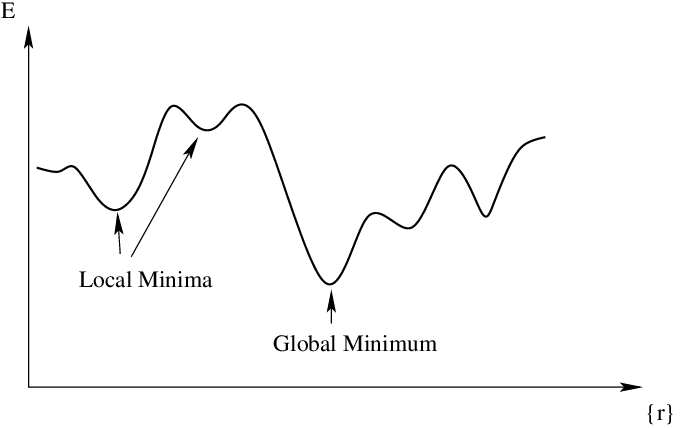

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1, n_init=30)

# On concaténe les train et test pour avoir le jeu complet (avoir un maximum de données pour le non supervisé)
X_total = np.concatenate((Xtrain_Cheville, Xtest_Cheville), axis=0)
Y_total = np.concatenate((y_train, y_test), axis=0)
y_pred_kmeans_brut = kmeans.fit_predict(X_total)

# La fonction correspondance est nécessaire car K-Means donne des groupes 0,1,2,3,4 arbitraires
y_pred_kmeans_corrigé = correspondance(y_pred_kmeans_brut, Y_total)

/tmp/ipykernel_189500/1865033827.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


### Évaluation K-Means

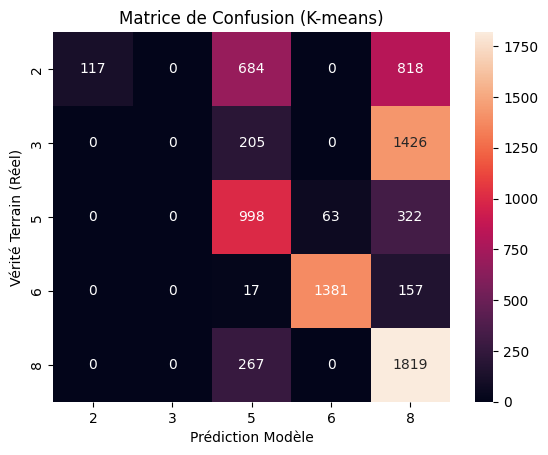

Pourcentage de bonne classification (K-means): 52.15%


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(Y_total, y_pred_kmeans_corrigé)

sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (K-means)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(Y_total, y_pred_kmeans_corrigé)
print(f"Pourcentage de bonne classification (K-means): {accuracy * 100:.2f}%")

#### Observations 
En essayant avec `n_init = 10 ou 20`, on a une précision de 42.37%. 

Avec un `n_init = 30`, on a une précision de 47.12, ce qui démontre que le placement originel des centroïdes est très important, et que l'on peut facilement tomber sur un minimum local et être bloqué. D'où l'envie d'augmenter le `n_init` pour avoir une probabilité plus faible de tomber sur des minimums locaux.

Néanmoins, la précision n'est clairement pas au rendez-vous. Cela peut s'expliquer par la séparation linéaire rigide de K-means, comme nous l´avons vu en cours (voir image ci-dessous). Contrairement au K Plus proche voisin qui est souple.

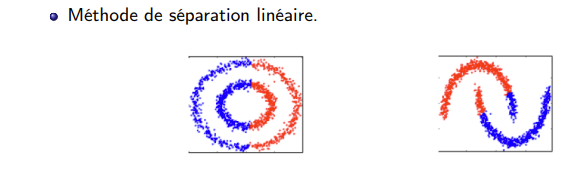

Enfin, la supervisation de l'apprentissage a une incidence. K-Means navigue dans le brouillard et doit trouver les frontières arbitrairement, tandis que des méthodes d'apprentissage supervisées peuvent plus logiquement lier le résultat aux mesures du capteur.
// TODO À développer

## Commentaires sur les méthodes supervisées utilisées et les résultats suivant les capteurs :
Que ce soit K plus proches voisins (KNN) ou K-Means, la problématique du nombre de dimensions se pose. La notion de proche ou de loin à l'échelle de 384 dimensions n'est pas très claire contrairement à un espace 1D, 2D ou 3D. 
Dans un espace à 384 dimensions, l'échantillon de quelques milliers de données n'est pas assez représentatif dans un espace aussi grand.
Enfin le bruit s'accumule et K-Means avec sa rigidité qui lui est propre, est très sensible au bruit.
A COMPLETER //TODO

# Partie II : Classification des activités avec prétraitement

- Réalisez maintenant une réduction de dimension par ACP. Expliquez quelle est la dimension la + intéressante.
- Appliquez les mêmes méthodes supervisées réalisées en TP et commentez les paramètres choisis. 
- Commentez les résultats. 

## Réduction de dimension par Analyse en Composantes Principales (ACP)

Réaliser une ACP pour réduire la dimension et visualiser les données. Discuter sur le choix de la dimension.

### Réduire nombre de dimensions
Comme dit précédemment, le nombre de dimensions est un frein à l'apprentissage car ajoute de l'obfuscation à notre jeu de données même si en soit il est très précis, trop précis.

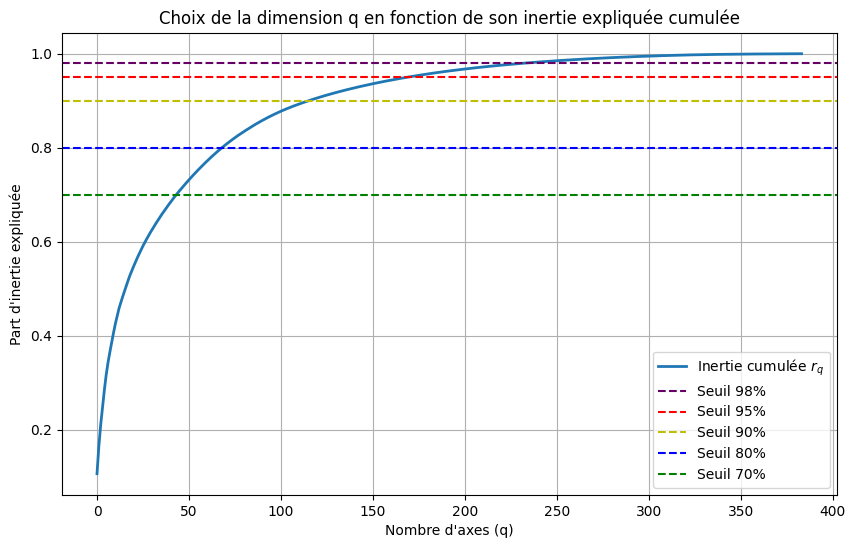

Dimension initiale p : 384
Dimension retenue q (pour 90% d'inertie) : 117


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Scikit-learn centre automatiquement les données (x - g) comme demandé diapo 13 
pca_full = PCA()
pca_full.fit(Xtrain_Cheville)

# Formule du ratio d'inertie (Diapo 20)
# ratio_inretie correspond à r_q dans le cours 
ratio_inertie = pca_full.explained_variance_ratio_
cum_var = np.cumsum(ratio_inertie)

plt.figure(figsize=(10, 6))
plt.plot(cum_var, linewidth=2, label="Inertie cumulée $r_q$")
plt.axhline(y=0.98, color=(0.4,0.0,0.4), linestyle='--', label='Seuil 98%')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil 95%')
plt.axhline(y=0.90, color='y', linestyle='--', label='Seuil 90%')
plt.axhline(y=0.80, color='b', linestyle='--', label='Seuil 80%')
plt.axhline(y=0.70, color='g', linestyle='--', label='Seuil 70%')
plt.title('Choix de la dimension q en fonction de son inertie expliquée cumulée')
plt.xlabel('Nombre d\'axes (q)')
plt.ylabel('Part d\'inertie expliquée')
plt.grid(True)

plt.legend()
plt.show()

# Calcul automatique du q pour 90%
q_optimal = np.argmax(cum_var >= 0.9) + 1
print(f"Dimension initiale p : {Xtrain_Cheville.shape[1]}")
print(f"Dimension retenue q (pour 90% d'inertie) : {q_optimal}")

#### Observations
On voit bien que de 0 à 25 axes, la part d'inertie expliquée est exponentiel. Réduire à moins d'axes, serait une énorme perte d'information. 

Après 25, la pente de la part d'inertie expliquée a tendance à moins croitre mais croit toujours fortement. Ce serait donc quand même une perte d'information importante.

On peut observer qu'après 150, 200 axes, le nombre de dimensions continue d'augmenter fortement pour une part d'inertie expliquée qui commence à converger.

À partir de 300, la part d'inertie expliquée est bornée donc il y a 84 dimensions sont superflus.

Ainsi on pourrait garder 
- 100% de l'information en supprimant 84 dimensions.
- 90% de l'information en supprimant la moitié des dimensions.

### Projection sur un plan 2D

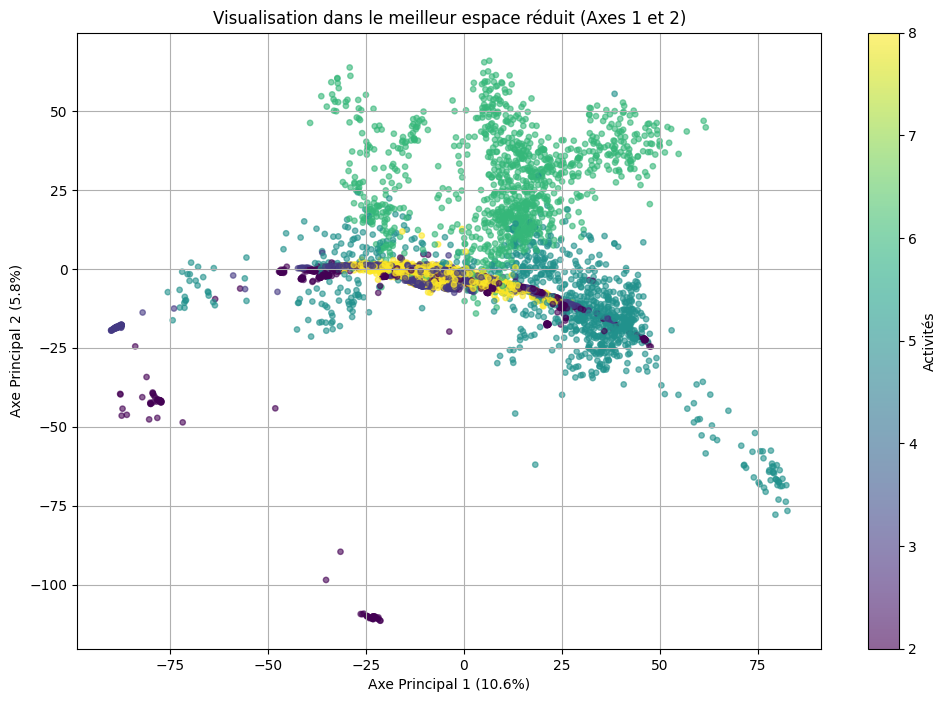

In [16]:
# Projection sur le plan factoriel (q=2)
pca_2d = PCA(n_components=2)
X_proj_2d = pca_2d.fit_transform(Xtrain_Cheville)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_proj_2d[:, 0], X_proj_2d[:, 1], c=y_train, cmap='viridis', alpha=0.6, s=15)
plt.title("Visualisation dans le meilleur espace réduit (Axes 1 et 2)")
plt.xlabel(f"Axe Principal 1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"Axe Principal 2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)")
plt.colorbar(scatter, label='Activités')
plt.grid(True)
plt.show()

In [17]:
var_2d = sum(pca_2d.explained_variance_ratio_) * 100

print(f"Variance expliquée cumulée sur le plan 2D : {var_2d:.2f}%")

Variance expliquée cumulée sur le plan 2D : 16.43%


#### Observations
On peut distinguer un peu groupes de points malgré une réduction des dimensions mais les groupes ne sont pas assez dissociés pour pouvoir clairement distinguer les groupes. C'est normal car en ayant que 2 dimensions, la variance expliquée cumulée sur le plan 2D est de 16.43%.

### Projection sur 3 axes (3D) 
Pour le fun, essayons de projeter sur 3 axes

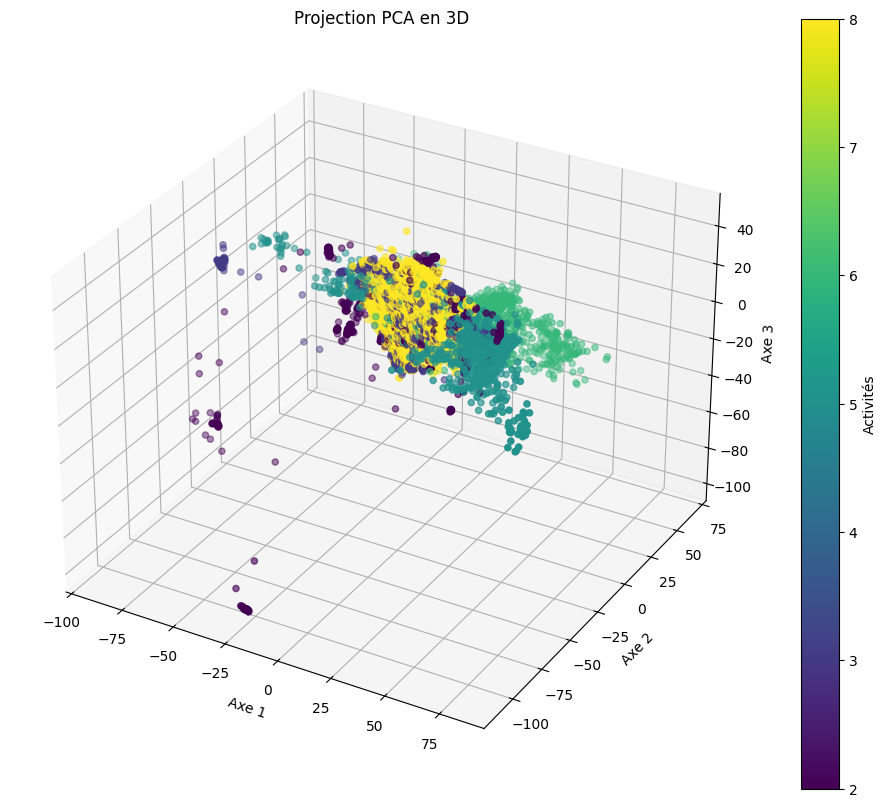

In [18]:
# 1. Calcul PCA sur 3 dimensions
pca_3d = PCA(n_components=3)
X_proj_3d = pca_3d.fit_transform(Xtrain_Cheville)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_proj_3d[:, 0], 
    X_proj_3d[:, 1], 
    X_proj_3d[:, 2], 
    c=y_train, 
    cmap='viridis', 
)

ax.set_xlabel('Axe 1')
ax.set_ylabel('Axe 2')
ax.set_zlabel('Axe 3')
ax.set_title("Projection PCA en 3D")
plt.colorbar(scatter, label='Activités')
plt.show()

In [19]:
var_3d = sum(pca_3d.explained_variance_ratio_) * 100

print(f"Variance expliquée cumulée sur le plan 3D : {var_3d:.2f}%")

Variance expliquée cumulée sur le plan 3D : 21.03%


#### Observations
En augmentant d'une seule dimension (passant de 2D à 3D), on gagne 5%. On constate bien la croissance exponentielle de la part de variance expliquée entre 0 et 25 comme vu précédemment. Les donnés sont très compactes.

## Apprentissages après ACP
### Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Après avoir réalisé une ACP sur l'ensemble d'apprentissage pour réduire la dimension 
puis projeter les données de l'ensemble de test dans la base de l'ACP, appliquez les deux méthodes supervisées. 

#### Choix du nombre d'axes optimal `q`.
Personnellement, j'ai choisi de garder environ 90% pour avoir le meilleur compris : garder l'information tout en réduisant les dimensions.

In [20]:
pca = PCA(n_components=q_optimal)
pca.fit(Xtrain_Cheville) # Calcul des vecteurs propres v

# Projection des données (X_c * v)
X_train_pca = pca.transform(Xtrain_Cheville)
X_test_pca = pca.transform(Xtest_Cheville)

#### Apprentissage Bayésien

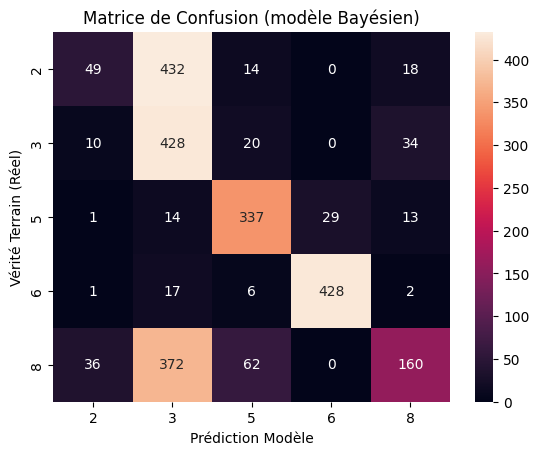

Pourcentage de bonne classification (modèle Bayésien): 56.46%


In [21]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train_pca, y_train)

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, gnb_model.predict(X_test_pca))
sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (modèle Bayésien)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(y_test, gnb_model.predict(X_test_pca))
print(f"Pourcentage de bonne classification (modèle Bayésien): {accuracy * 100:.2f}%")

##### Observations
On garde les mêmes performances que précédemment malgré la réduction des dimensions.
La classification Bayésienne n'est pas trop sensible aux nombres de dimensions.
Il sera plus intéressant de voir la différence pour les méthodes qui sont sensibles au fléau de la dimension (EN: curse of dimensionality) comme K-Means ou K plus proches voisins.

#### Apprentissage K plus proches voisins (EN: kNN) (k=5)

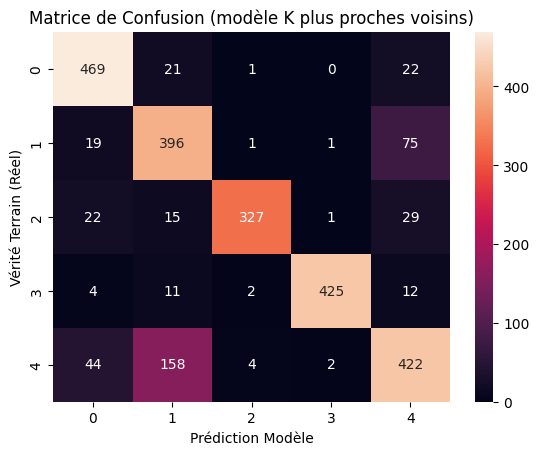

Pourcentage de bonne classification (modèle K plus proches voisins): 82.12%


In [22]:
from sklearn.neighbors import KNeighborsClassifier
# Avec k=5 car on a 5 classes (2-Assis,3-Debout, 5-Velo, 6-Marche Nordique, 8-Repassage)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, knn.predict(X_test_pca))
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"Matrice de Confusion (modèle K plus proches voisins)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(y_test, knn.predict(X_test_pca))
print(f"Pourcentage de bonne classification (modèle K plus proches voisins): {accuracy * 100:.2f}%")

##### Observations
// TODO

## Méthodes non supervisées avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Après avoir réalisé une ACP sur l'ensemble d'apprentissage pour réduire la dimension puis projeter les données de l'ensemble de test dans la base de l'ACP, appliquez les deux méthodes supervisées. 

### K-Means

/tmp/ipykernel_189500/1865033827.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


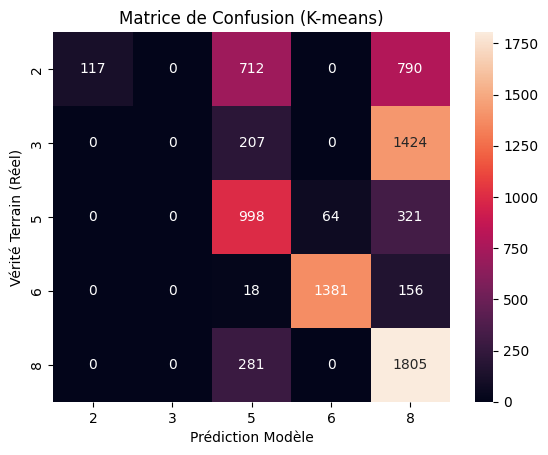

Pourcentage de bonne classification (K-means): 51.98%


In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1, n_init=30)

# On concaténe les train et test pour avoir le jeu complet (avoir un maximum de données pour le non supervisé)
X_total = np.concatenate((X_train_pca, X_test_pca), axis=0)
Y_total = np.concatenate((y_train, y_test), axis=0)
y_pred_kmeans_brut = kmeans.fit_predict(X_total)

# La fonction correspondance est nécessaire car K-Means donne des groupes 0,1,2,3,4 arbitraires
y_pred_kmeans_corrigé = correspondance(y_pred_kmeans_brut, Y_total)

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(Y_total, y_pred_kmeans_corrigé)

sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (K-means)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(Y_total, y_pred_kmeans_corrigé)
print(f"Pourcentage de bonne classification (K-means): {accuracy * 100:.2f}%")


## Commentaires sur les méthodes supervisée et non supevisée utilisées et les résultats

A COMPLETER

# Bilan de l'analyse 

A COMPLETER
// TODO

# Axe d'amélioration

## Normaliser les données ? 

À quoi ca servirait ? On va réduire les extremums. Typiquement, on pourrait imaginer un capteur dysfonctionnant et qui envoit 1000 km/s⁻2. Cela va avoir une énorme répercussion sur les autres données et par conséquent sur l'apprentissage. Normaliser, permettrait de limiter cet impact.
En revanche, on va tout de même garder la problématique logique qui est la confusion entre debout et repassage même en normalisant.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain_Cheville_norm_pca = scaler.fit_transform(X_train_pca)
Xtest_Cheville_norm_pca = scaler.transform(X_test_pca)

# Vérification
print(f"Moyenne après norm: {Xtrain_Cheville_norm_pca.mean():.2f}") # Doit être proche de 0
print(f"Ecart-type après norm: {Xtrain_Cheville_norm_pca.std():.2f}") # Doit être proche de 1

Moyenne après norm: -0.00
Ecart-type après norm: 1.00


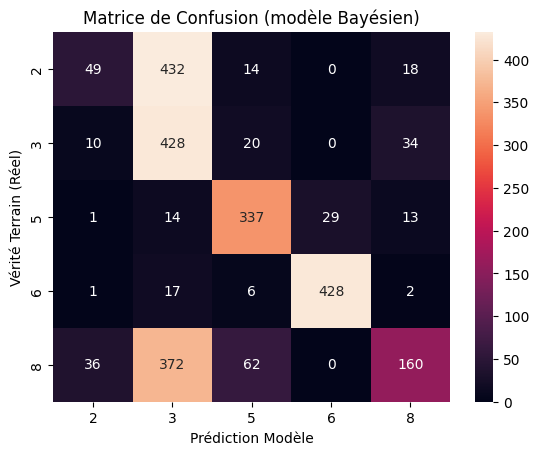

Pourcentage de bonne classification (modèle Bayésien): 56.46%


In [25]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(Xtrain_Cheville_norm_pca, y_train)

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, gnb_model.predict(Xtest_Cheville_norm_pca))
sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (modèle Bayésien)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(y_test, gnb_model.predict(Xtest_Cheville_norm_pca))
print(f"Pourcentage de bonne classification (modèle Bayésien): {accuracy * 100:.2f}%")

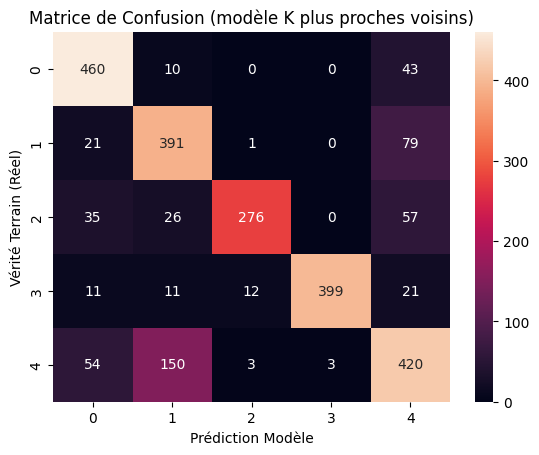

Pourcentage de bonne classification (modèle K plus proches voisins): 78.37%


In [26]:
from sklearn.neighbors import KNeighborsClassifier
# Avec k=5 car on a 5 classes (2-Assis,3-Debout, 5-Velo, 6-Marche Nordique, 8-Repassage)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtrain_Cheville_norm_pca, y_train)

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, knn.predict(Xtest_Cheville_norm_pca))
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"Matrice de Confusion (modèle K plus proches voisins)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(y_test, knn.predict(Xtest_Cheville_norm_pca))
print(f"Pourcentage de bonne classification (modèle K plus proches voisins): {accuracy * 100:.2f}%")

/tmp/ipykernel_189500/1865033827.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


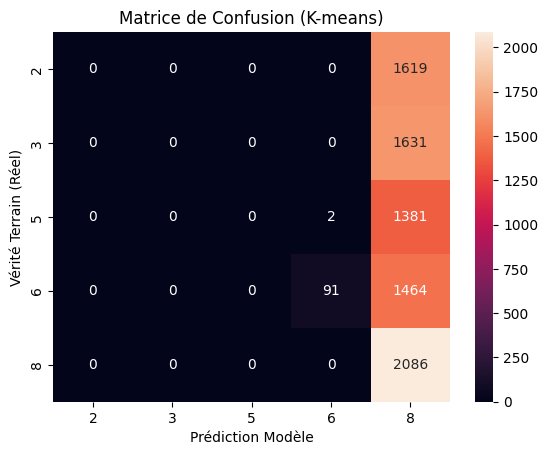

Pourcentage de bonne classification (K-means): 26.31%


In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1, n_init=30)

# On concaténe les train et test pour avoir le jeu complet (avoir un maximum de données pour le non supervisé)
X_total = np.concatenate((Xtrain_Cheville_norm_pca, Xtest_Cheville_norm_pca), axis=0)
Y_total = np.concatenate((y_train, y_test), axis=0)
y_pred_kmeans_brut = kmeans.fit_predict(X_total)

# La fonction correspondance est nécessaire car K-Means donne des groupes 0,1,2,3,4 arbitraires
y_pred_kmeans_corrigé = correspondance(y_pred_kmeans_brut, Y_total)

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(Y_total, y_pred_kmeans_corrigé)

sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=[2,3,5,6,8], yticklabels=[2,3,5,6,8])
plt.title(f"Matrice de Confusion (K-means)")
plt.ylabel("Vérité Terrain (Réel)")
plt.xlabel("Prédiction Modèle")
plt.show()

accuracy = accuracy_score(Y_total, y_pred_kmeans_corrigé)
print(f"Pourcentage de bonne classification (K-means): {accuracy * 100:.2f}%")
